In [364]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import savemat
from scipy.fft import fft, fftshift

In [240]:
DATADIR = Path("/Users/williamjenkins/Research/Projects/BOGP/Data/SWELLEX96/VLA/selected")
contents = np.load(DATADIR / "merged.npz")
x = contents["X"]
# t = contents["t"]

In [368]:
fs = 1500
M = x.shape[1]
NT = 350
N_snap = x.shape[0] // NT
NFFT = 2 ** 13

freq = 232

In [369]:
def find_freq_bin(fvec, X, f0):
    f_lower = f0 - 1
    f_upper = f0 + 1
    ind = (fvec >= f_lower) & (fvec < f_upper)
    data = (np.abs(X).sum(axis=1) / M)
    data[~ind] = -2009
    return np.argmax(data)

# fvec = np.linspace(0, 1500 / 2 - 1 / NFFT, NFFT)
fvec = (fs / NFFT) * np.arange(0, NFFT)

# x[:, 42] = 0 # Remove corrupted channel
x[:, 42] = x[:, [41,43]].mean(axis=1)

p = np.zeros((NT, M), dtype=complex)
for i in range(NT):
    idx_start = i * N_snap
    idx_end = (i + 1) * N_snap

    X = fft(x[idx_start:idx_end], n=NFFT, axis=0)
    # X = fftshift(X)
    fbin = find_freq_bin(fvec, X, freq)
    # print(fvec[fbin])
    p[i] = X[fbin]


(0.0, 2.0)

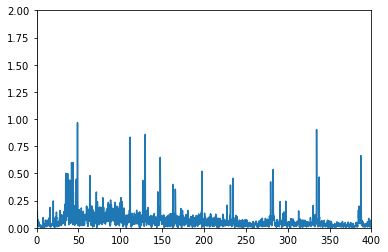

In [370]:
plt.plot(fvec, np.abs(X[:, 0]))
plt.xlim([0, 400])
plt.ylim([0, 2])

## Beamforming

In [371]:
c = 1500
l = c / freq
d = 1.875
q = np.arange(M, dtype=int) # Element index
# xq = np.expand_dims(((q - (M - 1) / 2) * d), 1)
xq = np.expand_dims(np.linspace(94.125, 212.25, 64), 1)

# Range of angle space
thetalim = [-50, 50]
theta_resolution = 0.1
# Angular search grid
theta = np.expand_dims(np.arange(thetalim[0], thetalim[1] + theta_resolution, theta_resolution), 1)

# Design (steering) matrix
sin_theta = np.sin(theta * (np.pi / 180))
sensing_matrix = np.exp(-1j * 2 * np.pi / l * xq * sin_theta.conj().T) / np.sqrt(M)


In [372]:
# fig = plt.figure(figsize=(12, 9))

sp = np.zeros((NT, len(theta)), dtype=complex)
for i in range(NT):
# i = 12
    d = np.expand_dims(p[i], 1)
    d /= np.linalg.norm(d)
    K = d.dot(d.conj().T)

    for j in range(len(theta)):
        w = np.expand_dims(sensing_matrix[:, j], 1)
        sp[i, j] = w.conj().T.dot(K).dot(w) / (w.conj().T.dot(w))

# plt.plot(np.abs(sp))

Text(0.5, 1.0, '232 Hz')

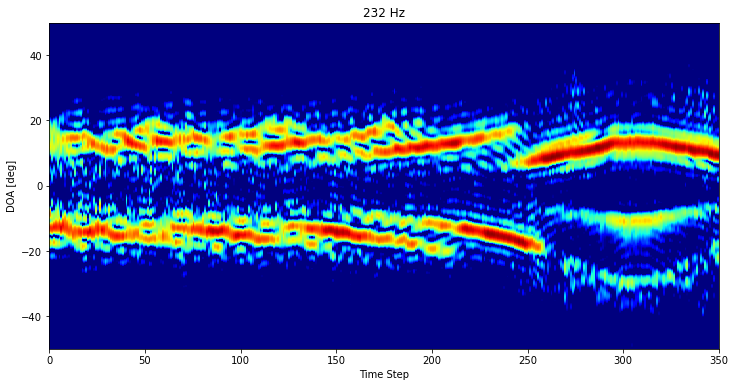

In [373]:
fig = plt.figure(figsize=(12, 6), facecolor="w")

surf = 10 * np.log10(np.abs(sp) / np.abs(sp).max())
plt.imshow(
    surf.T,
    aspect="auto",
    vmin=-20,
    vmax=0,
    cmap="jet",
    extent=[0, 350, thetalim[0], thetalim[1]],
    interpolation="none",
    origin="lower"
)
plt.xlabel("Time Step")
plt.ylabel("DOA [deg]")
plt.title(f"{freq} Hz")

In [374]:
savemat(DATADIR / f"{freq}Hz_data.mat", {"f": freq, "p": p})

In [375]:
p.shape

(350, 64)

In [377]:
len(np.linspace(0.001, 10, 200))

200